## Event based

In [2]:
import climtas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
import numpy as np
import sparse
import dask

In [3]:
# A function that does both steps
def event_dataarray(da, events, column):
    """
    Given the result of find_events 'events' and its matching source
    data 'da', return a new DataArray using the indices from 'events'
    and the values from 'column'
    """
    
    # Create a sparse array from the coordinates and data
    # Sparse doesn't work with dates, need to convert to float.
    # Xarray will conveniently convert back to date for us at the end.
    if column.dtype == 'datetime64[ns]':
        col = column.values.astype("float")
    else:
        col = column
    
    s = sparse.COO([events[d] for d in da.dims],
                    col,
                    shape=da.shape)
    
    # It's more helpful to have a dense array, but let's only convert
    # what we need when we need it using dask
    
    # Add dask chunking
    d = dask.array.from_array(s, chunks='auto')
    
    # Add an operation that converts chunks to dense when needed
    def dense_block(b):
        return b.todense()
    dense = d.map_blocks(dense_block, dtype=d.dtype)
    
    # Use the input data's coordinates
    return xr.DataArray(dense, coords=da.coords)

In [4]:
# opening the input files with heatwave severity data 
thw_ds = xr.open_dataset('/g/data/e14/cp3790/Charuni/Tasmania/aus-coastal-sev.nc')
mhw_ds = xr.open_dataset('/g/data/e14/cp3790/Charuni/Tasmania/aus-ocean-sev-2.nc')

In [7]:
# using climtas.event.find_events to identify days where severity>1 for a minimum of 3 consecutive days 
thw_events = climtas.event.find_events(thw_ds.severity > 1, min_duration = 3)
thw_events

,time,latitude,longitude,event_duration
0,0,48,151,3
1,0,48,152,3
2,0,50,152,3
3,0,54,154,3
4,0,54,155,3
...,...,...,...,...
165334,13508,130,142,6
165335,13508,130,143,6
165336,13508,131,142,6
165337,13508,133,140,6


In [8]:
def get_coords(da, events):
    # Convert the index values to coordinates
    coords = {}
    for d in da.dims:
        coords[d] = da[d].values[events[d].values]
    
    # Also work out when the event ends
    coords['time_end'] = da['time'].values[events['time'].values + events['event_duration'].values-1]
    #coords['event_duration'] = coords['time_end'] - coords['time'] 
    coords['event_duration'] = events['event_duration'].values
    
    return pd.DataFrame(coords, index=events.index)

In [9]:
thw_new = get_coords(thw_ds, thw_events)
thw_new

,latitude,longitude,time,time_end,event_duration
0,-22.00,150.75,1982-01-01,1982-01-03,3
1,-22.00,151.00,1982-01-01,1982-01-03,3
2,-22.50,151.00,1982-01-01,1982-01-03,3
3,-23.50,151.50,1982-01-01,1982-01-03,3
4,-23.50,151.75,1982-01-01,1982-01-03,3
...,...,...,...,...,...
165334,-42.50,148.50,2018-12-26,2018-12-31,6
165335,-42.50,148.75,2018-12-26,2018-12-31,6
165336,-42.75,148.50,2018-12-26,2018-12-31,6
165337,-43.25,148.00,2018-12-26,2018-12-31,6


In [10]:
thw_new_df = thw_new.reset_index()
thw_new_df.set_index(['latitude', 'longitude'], inplace=True)
thw_new_df

index       time   time_end  event_duration
latitude longitude                                              
-22.00   150.75          0 1982-01-01 1982-01-03               3
         151.00          1 1982-01-01 1982-01-03               3
-22.50   151.00          2 1982-01-01 1982-01-03               3
-23.50   151.50          3 1982-01-01 1982-01-03               3
         151.75          4 1982-01-01 1982-01-03               3
...                    ...        ...        ...             ...
-42.50   148.50     165334 2018-12-26 2018-12-31               6
         148.75     165335 2018-12-26 2018-12-31               6
-42.75   148.50     165336 2018-12-26 2018-12-31               6
-43.25   148.00     165337 2018-12-26 2018-12-31               6
         148.25     165338 2018-12-26 2018-12-31               6

[165339 rows x 4 columns]

In [11]:
# using climtas.event.find_events to identify days where severity>1 for a minimum of 5 consecutive days (MHW events)
mhw_events = climtas.event.find_events(mhw_ds.severity > 1, min_duration = 5)
mhw_events

,time,latitude,longitude,event_duration
0,0,0,29,5
1,0,1,123,5
2,0,1,124,5
3,0,4,94,5
4,0,4,95,5
...,...,...,...,...
127727,13497,135,133,17
127728,13500,135,134,14
127729,13500,135,135,14
127730,13491,135,136,23


In [12]:
mhw_new = get_coords(mhw_ds, mhw_events)
mhw_new

,latitude,longitude,time,time_end,event_duration
0,-10.00,120.25,1982-01-01,1982-01-05,5
1,-10.25,143.75,1982-01-01,1982-01-05,5
2,-10.25,144.00,1982-01-01,1982-01-05,5
3,-11.00,136.50,1982-01-01,1982-01-05,5
4,-11.00,136.75,1982-01-01,1982-01-05,5
...,...,...,...,...,...
127727,-43.75,146.25,2018-12-15,2018-12-31,17
127728,-43.75,146.50,2018-12-18,2018-12-31,14
127729,-43.75,146.75,2018-12-18,2018-12-31,14
127730,-43.75,147.00,2018-12-09,2018-12-31,23


In [13]:
mhw_new_df = mhw_new.reset_index()
mhw_new_df.set_index(['latitude', 'longitude'], inplace=True)
mhw_new_df

index       time   time_end  event_duration
latitude longitude                                              
-10.00   120.25          0 1982-01-01 1982-01-05               5
-10.25   143.75          1 1982-01-01 1982-01-05               5
         144.00          2 1982-01-01 1982-01-05               5
-11.00   136.50          3 1982-01-01 1982-01-05               5
         136.75          4 1982-01-01 1982-01-05               5
...                    ...        ...        ...             ...
-43.75   146.25     127727 2018-12-15 2018-12-31              17
         146.50     127728 2018-12-18 2018-12-31              14
         146.75     127729 2018-12-18 2018-12-31              14
         147.00     127730 2018-12-09 2018-12-31              23
         147.25     127731 2018-12-13 2018-12-31              19

[127732 rows x 4 columns]

In [14]:
# merging the THW and MHW dataframes based on latitude and longitude 
df_merge_col = pd.merge(thw_new_df, mhw_new_df, on=['latitude', 'longitude'])
df_merge_col

index_x     time_x time_end_x  event_duration_x  index_y  \
latitude longitude                                                             
-22.0    150.75           0 1982-01-01 1982-01-03                 3      149   
         150.75           0 1982-01-01 1982-01-03                 3      557   
         150.75           0 1982-01-01 1982-01-03                 3     1008   
         150.75           0 1982-01-01 1982-01-03                 3     1291   
         150.75           0 1982-01-01 1982-01-03                 3     1615   
...                     ...        ...        ...               ...      ...   
-29.5    153.50      164567 2018-12-13 2018-12-15                 3   125538   
         153.50      164567 2018-12-13 2018-12-15                 3   126077   
         153.50      164567 2018-12-13 2018-12-15                 3   126430   
         153.50      164567 2018-12-13 2018-12-15                 3   126659   
         153.50      164567 2018-12-13 2018-12-15                 3   127100   

                       time_y time_end_y  event_duration_y  
latitude longitude                                          
-22.0    150.75    1982-01-02 1982-01-08                 7  
         150.75    1982-01-18 1982-01-26                 9  
         150.75    1982-03-04 1982-03-12                 9  
         150.75    1982-03-16 1982-03-21                 6  
         150.75    1982-03-29 1982-04-05                 8  
...                       ...        ...               ...  
-29.5    153.50    2018-03-30 2018-04-29                31  
         153.50    2018-06-10 2018-06-16                 7  
         153.50    2018-08-08 2018-08-15                 8  
         153.50    2018-09-21 2018-09-25                 5  
         153.50    2018-10-19 2018-11-18                31  

[22207677 rows x 8 columns]

In [15]:
del df_merge_col['index_y']
del df_merge_col['index_x']
df_merge_col

time_x time_end_x  event_duration_x     time_y  \
latitude longitude                                                      
-22.0    150.75    1982-01-01 1982-01-03                 3 1982-01-02   
         150.75    1982-01-01 1982-01-03                 3 1982-01-18   
         150.75    1982-01-01 1982-01-03                 3 1982-03-04   
         150.75    1982-01-01 1982-01-03                 3 1982-03-16   
         150.75    1982-01-01 1982-01-03                 3 1982-03-29   
...                       ...        ...               ...        ...   
-29.5    153.50    2018-12-13 2018-12-15                 3 2018-03-30   
         153.50    2018-12-13 2018-12-15                 3 2018-06-10   
         153.50    2018-12-13 2018-12-15                 3 2018-08-08   
         153.50    2018-12-13 2018-12-15                 3 2018-09-21   
         153.50    2018-12-13 2018-12-15                 3 2018-10-19   

                   time_end_y  event_duration_y  
latitude longitude                               
-22.0    150.75    1982-01-08                 7  
         150.75    1982-01-26                 9  
         150.75    1982-03-12                 9  
         150.75    1982-03-21                 6  
         150.75    1982-04-05                 8  
...                       ...               ...  
-29.5    153.50    2018-04-29                31  
         153.50    2018-06-16                 7  
         153.50    2018-08-15                 8  
         153.50    2018-09-25                 5  
         153.50    2018-11-18                31  

[22207677 rows x 6 columns]

In [16]:
#Calculating the overlap between THW and MHW events 
from datetime import datetime
from collections import namedtuple
Range = namedtuple('Range', ['start', 'end'])
overlap = []
for n in range (df_merge_col.shape[0]):
    mhw = Range(start=df_merge_col['time_y'][n], end=df_merge_col['time_end_y'][n])
    thw = Range(start=df_merge_col['time_x'][n], end=df_merge_col['time_end_x'][n])
    latest_start = max(mhw.start, thw.start)
    earliest_end = min(mhw.end, thw.end)
    delta = (earliest_end - latest_start).days + 1
    b = max(0, delta)
    overlap.append(b)

In [17]:
#Retaining only the THW events which had an overlap of at least one day with a MHW event; these are the co-occurring events
mod_fd = df_merge_col.assign(overlap_days = overlap)
thw_or_mhw = mod_fd[mod_fd.overlap_days != 0].reset_index()
thw_only = mod_fd[mod_fd.overlap_days == 0].reset_index()
thw_only

,latitude,longitude,time_x,time_end_x,event_duration_x,time_y,time_end_y,event_duration_y,overlap_days
0,-22.0,150.75,1982-01-01,1982-01-03,3,1982-01-18,1982-01-26,9,0
1,-22.0,150.75,1982-01-01,1982-01-03,3,1982-03-04,1982-03-12,9,0
2,-22.0,150.75,1982-01-01,1982-01-03,3,1982-03-16,1982-03-21,6,0
3,-22.0,150.75,1982-01-01,1982-01-03,3,1982-03-29,1982-04-05,8,0
4,-22.0,150.75,1982-01-01,1982-01-03,3,1983-03-31,1983-04-04,5,0
...,...,...,...,...,...,...,...,...,...
22144058,-29.5,153.50,2018-12-13,2018-12-15,3,2018-03-30,2018-04-29,31,0
22144059,-29.5,153.50,2018-12-13,2018-12-15,3,2018-06-10,2018-06-16,7,0
22144060,-29.5,153.50,2018-12-13,2018-12-15,3,2018-08-08,2018-08-15,8,0
22144061,-29.5,153.50,2018-12-13,2018-12-15,3,2018-09-21,2018-09-25,5,0


In [18]:
thw_or_mhw

,latitude,longitude,time_x,time_end_x,event_duration_x,time_y,time_end_y,event_duration_y,overlap_days
0,-22.0,150.75,1982-01-01,1982-01-03,3,1982-01-02,1982-01-08,7,2
1,-22.0,150.75,1982-03-03,1982-03-08,6,1982-03-04,1982-03-12,9,5
2,-22.0,150.75,1982-03-12,1982-03-14,3,1982-03-04,1982-03-12,9,1
3,-22.0,150.75,1982-04-04,1982-04-06,3,1982-03-29,1982-04-05,8,2
4,-22.0,150.75,1983-04-04,1983-04-11,8,1983-03-31,1983-04-04,5,1
...,...,...,...,...,...,...,...,...,...
63609,-29.5,153.50,2017-09-03,2017-09-06,4,2017-08-30,2017-09-04,6,2
63610,-29.5,153.50,2017-09-12,2017-09-14,3,2017-09-08,2017-09-12,5,1
63611,-29.5,153.50,2017-09-27,2017-09-30,4,2017-09-27,2017-10-11,15,4
63612,-29.5,153.50,2018-02-13,2018-02-16,4,2018-02-15,2018-02-20,6,2


In [19]:
def count_events(df):
    newpt=(np.NaN,np.NaN)
    event_pt=[]
    nevent=0
    for pt in zip(df['latitude'],df['longitude']):
        if pt != newpt:
            nevent=0
            newpt=pt
        else:
            nevent=nevent+1
        event_pt.append(nevent)
    return event_pt

In [20]:
thw_only['event']=count_events(thw_only)
thw_only

,latitude,longitude,time_x,time_end_x,event_duration_x,time_y,time_end_y,event_duration_y,overlap_days,event
0,-22.0,150.75,1982-01-01,1982-01-03,3,1982-01-18,1982-01-26,9,0,0
1,-22.0,150.75,1982-01-01,1982-01-03,3,1982-03-04,1982-03-12,9,0,1
2,-22.0,150.75,1982-01-01,1982-01-03,3,1982-03-16,1982-03-21,6,0,2
3,-22.0,150.75,1982-01-01,1982-01-03,3,1982-03-29,1982-04-05,8,0,3
4,-22.0,150.75,1982-01-01,1982-01-03,3,1983-03-31,1983-04-04,5,0,4
...,...,...,...,...,...,...,...,...,...,...
22144058,-29.5,153.50,2018-12-13,2018-12-15,3,2018-03-30,2018-04-29,31,0,22765
22144059,-29.5,153.50,2018-12-13,2018-12-15,3,2018-06-10,2018-06-16,7,0,22766
22144060,-29.5,153.50,2018-12-13,2018-12-15,3,2018-08-08,2018-08-15,8,0,22767
22144061,-29.5,153.50,2018-12-13,2018-12-15,3,2018-09-21,2018-09-25,5,0,22768


In [21]:
# Create a DataArray to use the event_dataarray function
event_coord=np.arange(thw_only['event'].max()+1)
event_coord

array([    0,     1,     2, ..., 43087, 43088, 43089])

In [22]:
shape_da=(event_coord.size,thw_ds.latitude.size,thw_ds.longitude.size)
dims_da=('event','latitude','longitude')
coords_da={'event':event_coord,
        'latitude':thw_ds.latitude,
        'longitude':thw_ds.longitude}

da=xr.DataArray(np.zeros(shape_da),dims=dims_da, coords=coords_da)

In [23]:
thw_2 = thw_only.set_index(['event','latitude','longitude'])
thw_2

,,,time_x,time_end_x,event_duration_x,time_y,time_end_y,event_duration_y,overlap_days
event,latitude,longitude,,,,,,,
0,-22.0,150.75,1982-01-01,1982-01-03,3,1982-01-18,1982-01-26,9,0
1,-22.0,150.75,1982-01-01,1982-01-03,3,1982-03-04,1982-03-12,9,0
2,-22.0,150.75,1982-01-01,1982-01-03,3,1982-03-16,1982-03-21,6,0
3,-22.0,150.75,1982-01-01,1982-01-03,3,1982-03-29,1982-04-05,8,0
4,-22.0,150.75,1982-01-01,1982-01-03,3,1983-03-31,1983-04-04,5,0
...,...,...,...,...,...,...,...,...,...
22765,-29.5,153.50,2018-12-13,2018-12-15,3,2018-03-30,2018-04-29,31,0
22766,-29.5,153.50,2018-12-13,2018-12-15,3,2018-06-10,2018-06-16,7,0
22767,-29.5,153.50,2018-12-13,2018-12-15,3,2018-08-08,2018-08-15,8,0


In [24]:
thw_only_ds = xr.Dataset({k: event_dataarray(da, thw_only, v)
                               for k, v in thw_2.items()})

thw_only_ds

,Array,Chunk
Bytes,7.79 GB,125.68 MB
Shape,"(43090, 137, 165)","(695, 137, 165)"
Count,125 Tasks,62 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,7.79 GB,125.68 MB
Shape,"(43090, 137, 165)","(695, 137, 165)"
Count,125 Tasks,62 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


In [25]:
# Now treat thw_or_mhw
thw_or_mhw['event']=count_events(thw_or_mhw)
event_coord=np.arange(thw_or_mhw['event'].max()+1)
shape_da=(event_coord.size,thw_ds.latitude.size,thw_ds.longitude.size)
dims_da=('event','latitude','longitude')
coords_da={'event':event_coord,
        'latitude':thw_ds.latitude,
        'longitude':thw_ds.longitude}

da=xr.DataArray(np.zeros(shape_da),dims=dims_da, coords=coords_da)
thw_or_mhw_2 = thw_or_mhw.set_index(['event','latitude','longitude'])
thw_or_mhw_ds = xr.Dataset({k: event_dataarray(da, thw_or_mhw, v)
                               for k, v in thw_or_mhw_2.items()})
thw_or_mhw_ds

<xarray.Dataset>
Dimensions:           (event: 117, latitude: 137, longitude: 165)
Coordinates:
  * event             (event) int64 0 1 2 3 4 5 6 ... 111 112 113 114 115 116
  * latitude          (latitude) float64 -10.0 -10.25 -10.5 ... -43.75 -44.0
  * longitude         (longitude) float64 113.0 113.2 113.5 ... 153.8 154.0
Data variables:
    time_x            (event, latitude, longitude) float64 dask.array<chunksize=(117, 137, 165), meta=np.ndarray>
    time_end_x        (event, latitude, longitude) float64 dask.array<chunksize=(117, 137, 165), meta=np.ndarray>
    event_duration_x  (event, latitude, longitude) int64 dask.array<chunksize=(117, 137, 165), meta=np.ndarray>
    time_y            (event, latitude, longitude) float64 dask.array<chunksize=(117, 137, 165), meta=np.ndarray>
    time_end_y        (event, latitude, longitude) float64 dask.array<chunksize=(117, 137, 165), meta=np.ndarray>
    event_duration_y  (event, latitude, longitude) int64 dask.array<chunksize=(117, 137, 165), meta=np.ndarray>
    overlap_days      (event, latitude, longitude) int64 dask.array<chunksize=(117, 137, 165), meta=np.ndarray>

In [26]:
thw_only_ds.to_netcdf('/g/data/e14/cp3790/Charuni/Heatwaves/thw-only.nc')

In [27]:
thw_or_mhw_ds.to_netcdf('/g/data/e14/cp3790/Charuni/Heatwaves/thw-or-mhw.nc')

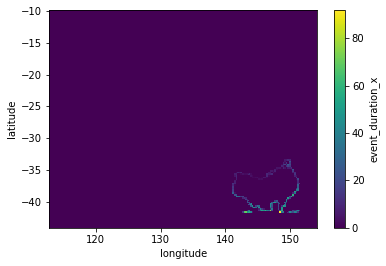

In [40]:
thw_or_mhw.event_duration_x.mean(dim='event').plot()

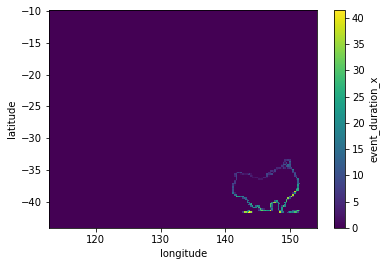

In [41]:
thw_only.event_duration_x.mean(dim='event').plot()